In [2]:
# imports
import numpy as np
from scipy.integrate import ode
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# import xflib
# xf = xflib.xflib(lib_path='/Users/austin/python_local/libxformd.so')

import matplotlib.gridspec as gridspec

from tempfile import NamedTemporaryFile
import base64 
from matplotlib import animation
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

from mpl_toolkits.basemap import Basemap

import gzip
import pickle



In [3]:
# # Let's do it totally realistically:
# q = -1.602e-19
# m = 9.1e-31
# B0 = 30e-6

R2D = 180.0/np.pi
D2R = np.pi/180.0
# R_E = 6371.
# import numpy as np
# from numpy import arctan2, sqrt
# # import numexpr as ne

def spherical_to_cartesian(r_in):
    x = r_in[0]*np.cos(D2R*r_in[1])*np.cos(D2R*r_in[2])
    y = r_in[0]*np.cos(D2R*r_in[1])*np.sin(D2R*r_in[2])
    z = r_in[0]*np.sin(D2R*r_in[1])
    #print x, y, z
    return np.array([x, y, z]).T

def cartesian_to_spherical(x_in):
    ''' cartesian to spherical (degrees)'''
    rads = np.linalg.norm(x_in,axis=0)
    lons = R2D*np.arctan2(x_in[1], x_in[0]);
    lats = R2D*np.arcsin(x_in[2]/rads)
    return np.array([rads, lats, lons]).T

def bfield(x_in):
    Bo = (3.12e-5)
    D2R = np.pi/180.
    R_E = 6371e3;

    R = x_in[0]
    theta = (90. - x_in[1])*D2R
    phi   = x_in[2]*D2R
    
    Bor3  = Bo*pow(R, -3.0)
    
    Brad = -2.0*Bor3*np.cos(theta);
    Btheta = -1.0*Bor3*np.sin(theta);
    Bphi = 0.0;    # Dipole model has no variation in longitude (here for completeness)

    B_out = np.zeros(3)
    B_out[0] = Brad;        # Up
    B_out[1] = Btheta;      # South
    B_out[2] = Bphi;        # East

    return B_out
def transform_data_sph2car(lat, lon, d_in):
    D2R = np.pi/180.

    M = np.zeros([3,3])
    d_out = np.zeros(3)

    theta = D2R*(90. - lat)
    phi   = D2R*lon

    st = np.sin(theta)
    sp = np.sin(phi)
    ct = np.cos(theta)
    cp = np.cos(phi)

    M[0,0] = st*cp;    M[0,1] = ct*cp;   M[0,2] = -sp;
    M[1,0] = st*sp;    M[1,1] = ct*sp;   M[1,2] = cp;
    M[2,0] = ct;       M[2,1] = -st;     M[2,2] = 0;

    d_out = np.dot(M, d_in)

    return d_out

def transform_data_car2sph(lat, lon, d_in):
    D2R = np.pi/180.

    M = np.zeros([3,3])
    d_out = np.zeros(3)

    theta = D2R*(90. - lat)
    phi   = D2R*lon

    st = np.sin(theta)
    sp = np.sin(phi)
    ct = np.cos(theta)
    cp = np.cos(phi)

    M[0,0] = st*cp;    M[0,1] = ct*cp;   M[0,2] = -sp;
    M[1,0] = st*sp;    M[1,1] = ct*sp;   M[1,2] = cp;
    M[2,0] = ct;       M[2,1] = -st;     M[2,2] = 0;

    d_out = np.dot(M.T, d_in)

    return d_out

In [6]:
def newton(t, Y, q, m, B):  
    """Computes the derivative of the state vector y according to the equation of motion:
    Y is the state vector (x, y, z, u, v, w) === (position, velocity).
    returns dY/dt.
    This version takes B as a vector.
    """
    x, y, z = Y[0], Y[1], Y[2]
    u, v, w = Y[3], Y[4], Y[5]
    
    dv = np.cross(Y[3:6], B)*q / m
    alpha = q / m * np.linalg.norm(B)
    
    return np.array([u, v, w, dv[0], dv[1], dv[2]])

In [4]:
# Load coastlines (for plotting)
with gzip.open('mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)
print coast.keys()

['lat', 'lon']


In [7]:
R2D = 180.0/np.pi
D2R = np.pi/180.0
R_E = 6371.

# Let's do it totally realistically:
q = -1.602e-19
m = (9.1e-31)*1   # Tripling the mass to make the radius more-visible
Bo = (3.12e-5)
c = 2.99e8
E_EL = 5.105396765648739e5
ke = 0.002        # electron energy in ev
alpha = 30        # equatorial pitch angle
L = 2.5  

t1 = 5e-4 # stop time
dt = 5e-8 # timestep 

vtot = c*np.sqrt(1 - pow( (E_EL/(E_EL+ke)),2))

x0_sph = np.array([L, 0, 0])

x0 = spherical_to_cartesian(x0_sph)
v0 = np.array([np.sin(alpha*D2R), 0, np.cos(alpha*D2R)])*vtot
initial_conditions = np.concatenate((x0, v0))

Bsph = bfield(x0_sph)
B = transform_data_sph2car(x0_sph[1], x0_sph[2], Bsph)

# Start the integrator
r = ode(newton).set_integrator('dopri5')
r.set_initial_value(initial_conditions, 0).set_f_params(q, m, B)

positions = []
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    positions.append(r.y[:3]) # keeping only position, not velocity
    
#     print "pos (car)", r.y[:3]
    xsph = cartesian_to_spherical(r.y[:3])
#     print "pos (sph)", xsph
    Bsph = bfield(xsph)

#     print B
    Bcar = transform_data_sph2car(xsph[1], xsph[2], Bsph)
#     print B2
#     print xsph, Bsph, Bcar
    

    r.set_f_params(q, m, Bcar)


positions = np.array(positions)

/shared/users/asousa/software/python2/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in less


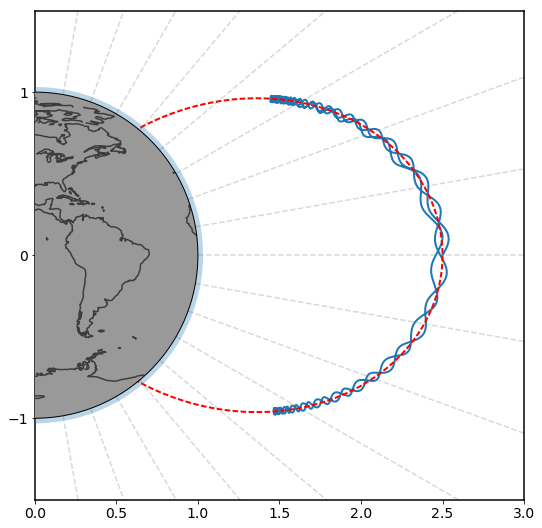

In [8]:


# --------------- Latex Plot Beautification --------------------------
fig_width = 8 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

fig, ax = plt.subplots(1,1)
[i.set_linewidth(1.5) for i in ax.spines.itervalues()]
ax.plot(positions[:,0], positions[:,2], linewidth=2)
ax.set_aspect('equal')
ax.set_xlim([0,L + 0.5])
ax.set_ylim(np.array([-1, 1])*(L + 0.5)/2.)
ax.set_yticks([ -1, 0, 1])
# Draw the earth
# Plot the earth
earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', zorder=100)
iono  = plt.Circle((0,0),1 + 200./6378.,alpha=0.3, zorder=99)
 
ax.add_patch(earth)                    # The earth (round)
ax.add_patch(iono)
coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
coastr = np.linalg.norm(coastpoints, axis=0)
coastmask = (coastr < 1) | (np.isnan(coastr))
ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.6)



# ax2=fig.add_axes([0,0.25,0.52,0.5])
# m = Basemap(projection='ortho',lon_0=-105,lat_0=-25,resolution='l',ax=ax2)
# m.bluemarble(scale=.5) # scale=.1 for low resolution

# Plot latitude lines:

for la in np.arange(-80, 81, 10):
    rr = np.array([1,10])
    plt.plot(rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', alpha=0.3)
    

# Plot the fieldlines
lam = np.linspace(-80,80,181)
L_r = L*pow(np.cos(lam*D2R),2)
Lx  = L_r*np.cos(lam*D2R)
Ly  = L_r*np.sin(lam*D2R)
ax.plot(Lx,Ly,color='r',linewidth=2,linestyle='dashed')  # Field line

/Users/austin/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in less


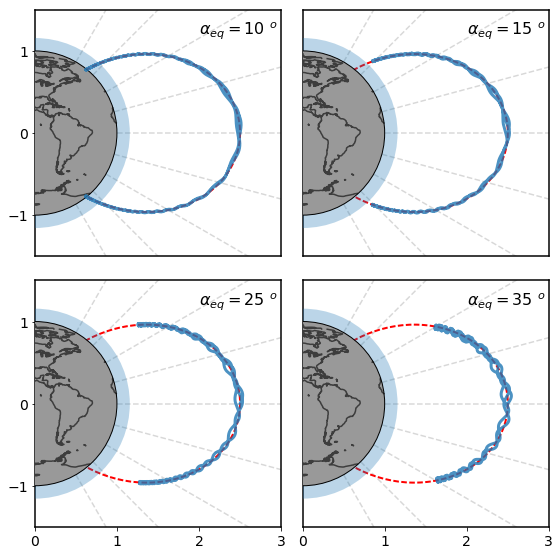

In [75]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 7 
fig_height = 7
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 16,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------





R2D = 180.0/np.pi
D2R = np.pi/180.0
R_E = 6371.

# Let's do it totally realistically:
q = -1.602e-19
m = (9.1e-31)*1   # Tripling the mass to make the radius more-visible
Bo = (3.12e-5)
c = 2.99e8
E_EL = 5.105396765648739e5
ke = 0.002        # electron energy in ev
alphas = [10, 15, 25, 35]        # equatorial pitch angle
L = 2.5 

t1 = 5e-4 # stop time
dt = 5e-8 # timestep 

fig, axlist = plt.subplots(2,2)

axlist = axlist.flatten()

for aind, alpha in enumerate(alphas):
    
    # -------- Do the integration ----------
    vtot = c*np.sqrt(1 - pow( (E_EL/(E_EL+ke)),2))
    x0_sph = np.array([L, 0, 0])
    x0 = spherical_to_cartesian(x0_sph)
    v0 = np.array([np.sin(alpha*D2R), 0, np.cos(alpha*D2R)])*vtot
    initial_conditions = np.concatenate((x0, v0))
    Bsph = bfield(x0_sph)
    B = transform_data_sph2car(x0_sph[1], x0_sph[2], Bsph)
    
    # Start the integrator
    r = ode(newton).set_integrator('dopri5')
    r.set_initial_value(initial_conditions, 0).set_f_params(q, m, B)

    positions = []
    while r.successful() and r.t < t1:
        r.integrate(r.t+dt)
        positions.append(r.y[:3]) # keeping only position, not velocity
        xsph = cartesian_to_spherical(r.y[:3])
        Bsph = bfield(xsph)
        Bcar = transform_data_sph2car(xsph[1], xsph[2], Bsph)
        r.set_f_params(q, m, Bcar)

    positions = np.array(positions)
    
    # ----- Plot it --------
    ax = axlist[aind]
    [i.set_linewidth(1.5) for i in ax.spines.itervalues()] # Set plot border thickness
    ax.plot(positions[:,0], positions[:,2], linewidth=3, zorder=102, alpha=0.8)
    ax.set_aspect('equal')
    ax.set_xlim([0,L + 0.5])
    ax.set_ylim(np.array([-1, 1])*(L + 0.5)/2.)
    ax.set_yticks([ -1, 0, 1])
    # Draw the earth
    # Plot the earth
    earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', zorder=100)
    iono  = plt.Circle((0,0),1 + 1000./6378.,alpha=0.3, zorder=99)

    ax.add_patch(earth)                    # The earth (round)
    ax.add_patch(iono)
    coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
    coastr = np.linalg.norm(coastpoints, axis=0)
    coastmask = (coastr < 1) | (np.isnan(coastr))
    ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.6)



    # ax2=fig.add_axes([0,0.25,0.52,0.5])
    # m = Basemap(projection='ortho',lon_0=-105,lat_0=-25,resolution='l',ax=ax2)
    # m.bluemarble(scale=.5) # scale=.1 for low resolution

    # Plot latitude lines:

    for la in np.arange(-60, 61, 15):
        rr = np.array([1,10])
        ax.plot(rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', alpha=0.3)

    # Plot the fieldlines
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax.plot(Lx,Ly,color='r',linewidth=2,linestyle='dashed', zorder=98)  # Field line
    
    ax.text(2, 1.2, r'$\alpha_{eq}=$%d $^o$'%alpha)

axlist[0].set_xticks([])    
axlist[1].set_xticks([])
axlist[1].set_yticks([])
axlist[3].set_yticks([])
axlist[2].set_xticks([0,1,2,3])
axlist[3].set_xticks([0,1,2,3])
fig.tight_layout()

fig.savefig('pitchangle_trapping_4up.png',ldpi=300)

In [62]:
# Loss-cone angle:
Bo_eq = np.linalg.norm(bfield([L, 0,0]))
lam_iono = np.arccos(np.sqrt((R_E + 1000.)/L/R_E))
B_iono = np.linalg.norm(Bo_eq*np.sqrt(1. + 3*pow(np.sin(lam_iono), 2))/pow(np.cos(lam_iono),6.))

alpha_lc = np.arcsin(np.sqrt(Bo_eq/B_iono))
print alpha_lc*R2D

14.3385374025


In [42]:
from methods.find_crossings import gen_EA_array
# --------------- Latex Plot Beautification --------------------------
fig_width = 10 
fig_height = 6
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 16,
          'font.size': 16,
          'legend.fontsize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

Lvec = np.arange(1.5, 5, 0.5)
Lmax = 4


fig, ax = plt.subplots(1,1)
[i.set_linewidth(1.5) for i in ax.spines.itervalues()]
# ax.plot(positions[:,0], positions[:,2], linewidth=2)
ax.set_aspect('equal')
ax.set_xlim([-Lmax - 0.8,Lmax + 0.8])
ax.set_ylim(np.array([-1, 1])*(Lmax + 0.5)/2.)
ax.set_yticks([ -1, 0, 1])
# Draw the earth
# Plot the earth
earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', zorder=100)
iono  = plt.Circle((0,0),1 + 1000./6378.,alpha=0.3, zorder=99)
 
ax.add_patch(earth)                    # The earth (round)
ax.add_patch(iono)
coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
coastr = np.linalg.norm(coastpoints, axis=0)
coastmask = (coastr < 1) | (np.isnan(coastr))
ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.6)



# ax2=fig.add_axes([0,0.25,0.52,0.5])
# m = Basemap(projection='ortho',lon_0=-105,lat_0=-25,resolution='l',ax=ax2)
# m.bluemarble(scale=.5) # scale=.1 for low resolution

# Plot latitude lines:

for la in np.arange(-90, 91, 10):
    rr = np.array([1,10])
    plt.plot(rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', alpha=0.3)
    plt.plot(-rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', alpha=0.3)

    

# Plot the fieldlines
lam = np.linspace(-80,80,181)
for L in Lvec:
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax.plot( Lx,Ly,color='r',linewidth=2,linestyle='dashed')  # Field line
    ax.plot(-Lx,Ly,color='r',linewidth=2,linestyle='dashed')  # Field line
    ax.text(L-0.2, 0, '%.1f'%L, size=14)
    
ax.set_xlabel('L (R$_E$)')
ax.set_ylabel('L (R$_E$)')
fig.tight_layout()
fig.savefig('dipole_field.png', dpi=300)

ImportError: No module named methods.find_crossings